# Testing DVR on different wallpaper groups

In [1]:
# importing packages
from ripser import ripser
from persim import plot_diagrams
from numpy import pi,sin,cos
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from math import dist
from math import sqrt
from math import ceil
from PIL import Image
from PIL import ImageFilter
from IPython.display import display
import glob
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances

# New imports spring study
import gudhi as gd
import imp
import DVR
from gudhi import wasserstein
import cv2
from PIL import ImageOps

C:\Users\dinko\AppData\Local\Temp\ipykernel_14752\1859279180.py:21: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
# FUNCTIONS NEEDED FOR METHOD 1


# the function get_pixels outputs a list of points (x,y) that represent our "pixels"
# the length of this list is (num_pixels)^2
# the pixels are arranged in a grid of size [window_size x window_size] centered around (0,0) 
def get_pixels(num_pixels, window_size):
    sample = list(np.linspace(-window_size/2, window_size/2, num_pixels))
    pixels = []
    for i in range(len(sample)):
        for j in range(len(sample)):
            pixels.append((sample[i],sample[j]))     
    return pixels



# given an image function f:R^2 --> R and a set of pixels, 
# get_colors outputs a list that tracks the color associated to each pixel
def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors  



# view_window allows us to view our "image" given a number of pixels and the size of the window
def view_window(image_function, num_pixels, window_size):
    pixels = get_pixels(num_pixels, window_size)  
    x_points = []
    y_points = []
    colors = []
    for i in range(len(pixels)):
        color = image_function(pixels[i][0],pixels[i][1]) 
        colors.append(color)
        x_points.append(pixels[i][0])
        y_points.append(pixels[i][1])
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = colors)
    plt.show()



# the following four functions work together to output a list of functions/isometries
# each function/isometry is a combination of a translation and rotation of the Cartesian plane
# note that generate_isom actually outputs the inverse of each isometry 
# the inverse isometry is what allows us to find the new colors of the pixels in the window under an isometry 
def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab
def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta
def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso
def generate_isom(n_isos, x_translate, y_translate): # x_translate and y_translate are bounds for sampling translations (not as important when function is defined on all of R^2)
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) 
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) 
    theta = list(2 * pi * np.random.random(n_isos)) 
    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv




# given an inverse isometry iso_inv, new_colors uses get_colors to assign new colors to each pixel
def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors




# given a list of inverse isometries isos_inv, matrix_of_images organizes the pixel colors into a matrix
# each row corresponds to a coloring of the pixels under a different isometry 
def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M



# with a matrix of images, phom runs the ripser function to calculate the persistent homology 
# can choose maximum dimension of homology to calculate (we choose maxdim = 1)
# coeff = n indicates that the homology vector space is built over the integers modulo n
def p_hom(M, maxdim, coeff):
    output = ripser(M, maxdim = maxdim, coeff = coeff)
    return output
    
    
    
# given the output from ripser, persistent_H1_intervals return the length of each H1 interval, largest to smallest
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    d
    return d[:10]



# given the output from ripser, plot_dgms displays the persistence diagrams
def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)
    
    
    
# pipeline sets up the pixels, isometries, and matrix and runs ripser all in one! 
def pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

In [3]:
# FUNCTIONS NEEDED FOR METHOD 2

# Given an image, a lens size, and a translation, this translation_snapshot() 
# returns a snapshot after the translation is performed.
def translation_snapshot(img, lens_sz, translation):
    (a,b) = translation 
    translation = (-a,-b)
    (x,y) = upper_left_center(img, translation)
    (length, height) = img.size
    
    lens_corner_x = x - lens_sz/2.0 
    lens_corner_y = y - lens_sz/2.0 
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img



# Given a point with the origin at the center of the image, upper_left_center()
# returns the same point but with coordinates with an origin at the top left corner. 
# This is a helper function for translation_snapshot().
def upper_left_center(img, center):
    (x,y) = center
    (l, h) = img.size
    return (l/2.0+x , h/2.0 - y) 



# Given an image, a lens size, and an isometry, create_snapshot() performs the 
# isometry on the image and returns a lens size view of the image
def create_snapshot(img, lens_sz, isometry):
    (x,y,rotation) = isometry
    translation = (x,y)
    # turn from radian to degree
    rotation = 57.2958*rotation
    rot_img = img.rotate(rotation)
    return translation_snapshot(rot_img, lens_sz, translation)



# get_pixel_isom() converts a list of isometries into a list of the associated 
# pixel vector embeddings
def get_pixel_isom(isoms, img, lens):
    isom_images = []
    for iso in isoms:
        isom_images.append(create_snapshot(img, lens, iso))
    ret_lst = []
    for elem in isom_images:
        arr = np.asarray(elem)
        arr = arr.reshape(-1)
        ret_lst.append(arr)
    ret_lst = np.asarray(ret_lst)
    return ret_lst



# generate a list of random isometries such that the lens does not fall off of the page
def generate_isoms(img, lens_sz, n_samples):
    lens_range = ((min(img.size)/sqrt(2))-lens_sz)/2.0
    x_trans = (lens_range*2*np.random.random(n_samples) - lens_range)
    y_trans = (lens_range*2*np.random.random(n_samples) - lens_range)
    rotations = (2*pi*np.random.random(n_samples))
    isoms = []
    for i in range(n_samples):
        isoms.append((x_trans[i], y_trans[i], rotations[i]))
    return isoms



# generate a persistent homology graph with ripser and show the H1 intervals
def persistent_homology(img, lens_sz, n_samples, c):
    isoms = generate_isoms(img, lens_sz, n_samples)
    data = get_pixel_isom(isoms, img, lens_sz)
    
    # make persistent homology plot with ripser
    res = ripser(data, maxdim=1,  coeff =c)
    dgms = res['dgms']
    plt.figure(figsize = (4,4)) 
    plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")
    plot_diagrams(dgms)

    # see how many points are persisting
    # H1 = res['dgms'][1].tolist() # all intervals in H1
    # d = []
    # for pair in H1: 
    #     d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    # d.sort(reverse = True) # sorting from longest to shortest intervals
    # print("largest 7 lengths of H1 intervals")
    # print(d[:7])
    


## Point Group $C_4$

## **Method 2:**

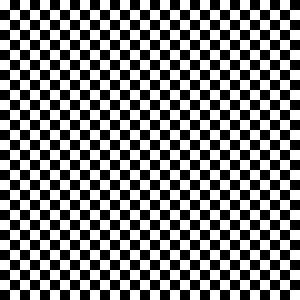

In [16]:
img = Image.open('../images/smallcheck.jpeg')
img = img.convert('L')
display(img)

In [17]:
isoms = generate_isoms(img, 30, 750)
data = get_pixel_isom(isoms, img, 30)


C:\Users\dinko\anaconda3\envs\persistent-homology\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


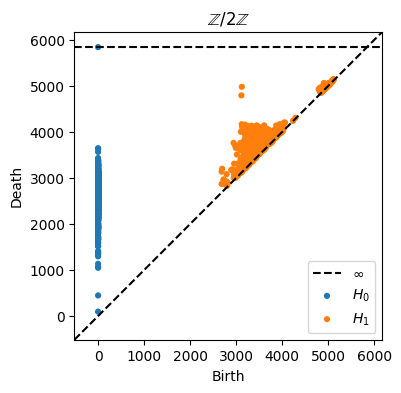

In [9]:
c= 2
res = ripser(data, maxdim=1,  coeff =c)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")
plot_diagrams(dgms)

C:\Users\dinko\anaconda3\envs\persistent-homology\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


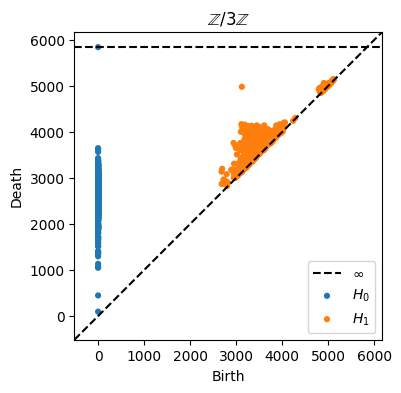

In [10]:
c= 3
res = ripser(data, maxdim=1,  coeff =c)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")
plot_diagrams(dgms)

Set k =  8


C:\Users\dinko\anaconda3\envs\persistent-homology\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

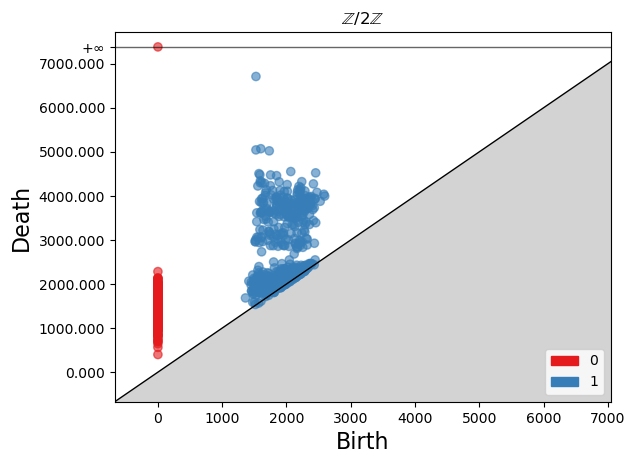

In [6]:
c = 2
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

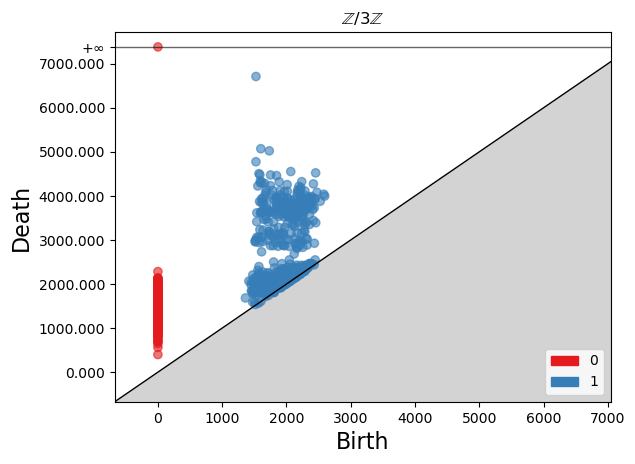

In [7]:
c = 3
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [8]:
geo_ph

[(1, (1524.836637010575, 6708.520460285292)),
 (1, (1600.1442233865623, 5069.483633711327)),
 (1, (1732.2309165079673, 5021.090774501625)),
 (1, (1524.7453500499466, 4773.469066295789)),
 (1, (1571.5901094857572, 4504.076778301638)),
 (1, (1586.4262516929143, 4478.404492316334)),
 (1, (1593.9157251195616, 4340.9287918066275)),
 (1, (1752.3718470698332, 4474.398373832293)),
 (1, (1592.0306645645167, 4296.189497396224)),
 (1, (1619.0237914311726, 4299.268105180055)),
 (1, (1554.2097949527865, 4223.80580388775)),
 (1, (1659.1713622029354, 4284.74867207599)),
 (1, (1845.657600873227, 4458.82626830809)),
 (1, (2066.5726085011047, 4551.5647362535165)),
 (1, (1749.3150240088548, 4230.958933728156)),
 (1, (1685.20585513894, 4139.915745859789)),
 (1, (1885.699139868718, 4318.816049526059)),
 (1, (1673.2913539731708, 4065.644558724737)),
 (1, (1784.4771917439257, 4122.447477177713)),
 (1, (1672.5383540736025, 4009.83463947725)),
 (1, (1615.3137296977302, 3937.0440565125073)),
 (1, (1632.96707434

In [9]:
geo_cpx1.persistence_intervals_in_dimension(1)

array([[1515.98214815, 1535.70394022],
       [1567.24450258, 1567.58113903],
       [1474.9182126 , 1585.47456356],
       ...,
       [1524.74535005, 5042.6733186 ],
       [1600.14422339, 5069.48363371],
       [1524.83663701, 6708.52046029]])

In [13]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

269.204252300573

In [14]:
gd.bottleneck_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

247.6217082058356

In [33]:
for i in zip(geo_cpx1.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

(array([1732.23091651, 5021.0907745 ]), array([1524.74535005, 4773.4690663 ]))
(array([1524.74535005, 5042.6733186 ]), array([1732.23091651, 5021.0907745 ]))


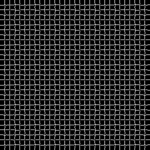

In [7]:
opencv_image=cv2.imread('../images/smallcheck.jpeg', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(opencv_image,100,200)
color_converted = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
pil_image=Image.fromarray(color_converted)
pil_image = ImageOps.scale(pil_image, .5)
display(pil_image)


In [9]:
isoms = generate_isoms(pil_image, 10, 750)
data = get_pixel_isom(isoms, pil_image, 10)


Set k =  8
CPU times: total: 1min 39s
Wall time: 3min 24s


C:\Users\dinko\anaconda3\envs\persistent-homology\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

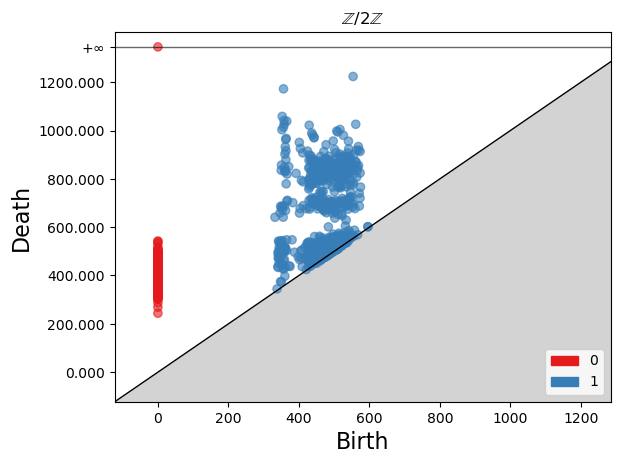

In [10]:
%%time
c = 2
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8
CPU times: total: 1min 39s
Wall time: 3min 19s


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

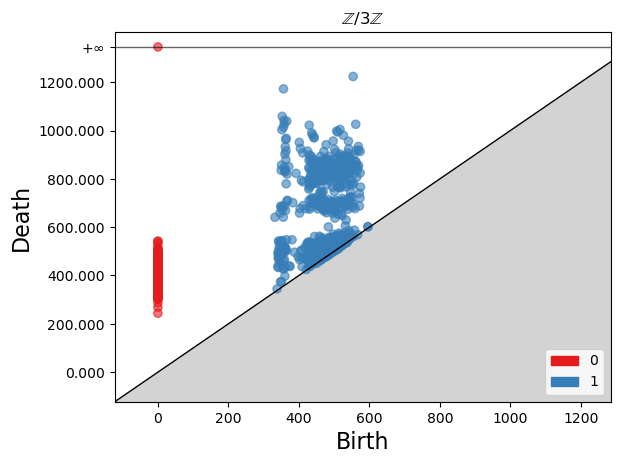

In [12]:
%%time
c = 3
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [15]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

0.0

Set k =  8
CPU times: total: 1min 43s
Wall time: 3min 16s


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

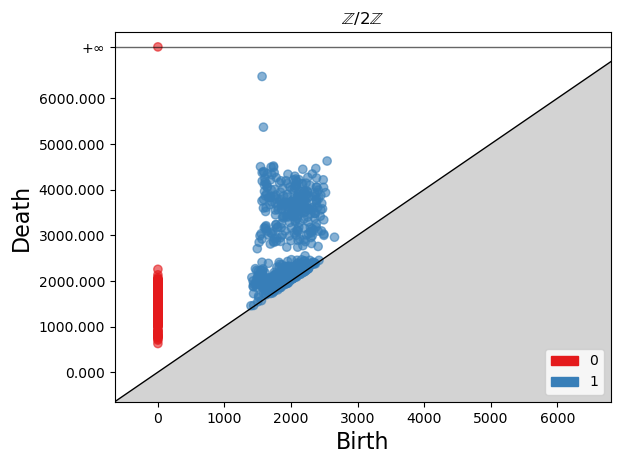

In [18]:
%%time
c = 2
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8
CPU times: total: 1min 42s
Wall time: 3min 17s


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

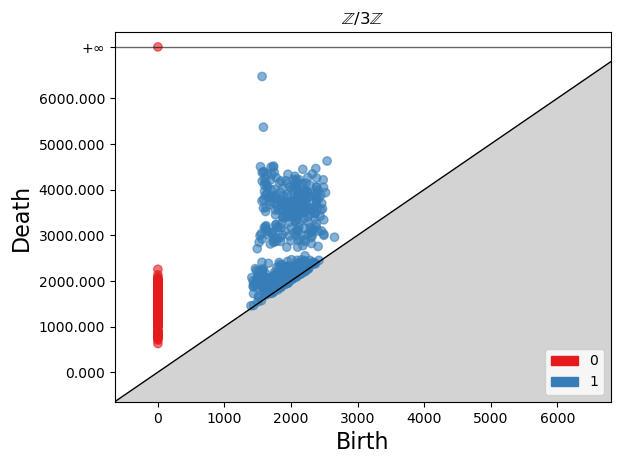

In [19]:
%%time
c = 3
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [20]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

872.6958365698729

In [21]:
for i in zip(geo_cpx1.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

(array([1541.28417536, 4503.35946988]), array([1585.56500554, 4496.4517428 ]))
(array([1736.16434108, 4517.45516817]), array([1541.28417536, 4503.35946988]))
(array([2542.14781795, 4627.49881134]), array([1736.16434108, 4517.45516817]))
(array([1585.56500554, 5369.14757937]), array([2542.14781795, 4627.49881134]))


## **Method 1:**

In [61]:
def c4(x,y): 
    if 0 <= x%2 < 1 and 0 <= y%2 < 1:
        res = 1 
    elif 1 <= x%2 < 2 and 1 <= y%2 < 2:
        res = 1
    else: 
        res = 0
    return res

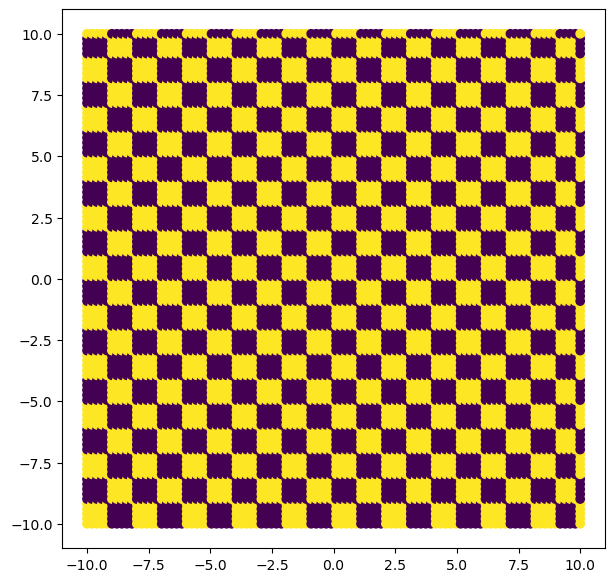

In [71]:
view_window_continuous(c4,100,20)

In [72]:
# coeff = 2
output = pipeline(image_function = c4, num_pixels = 40, window_size = 5, n_isos = 2000, x_translate = 100, y_translate = 100, maxdim = 1, coeff = 2)

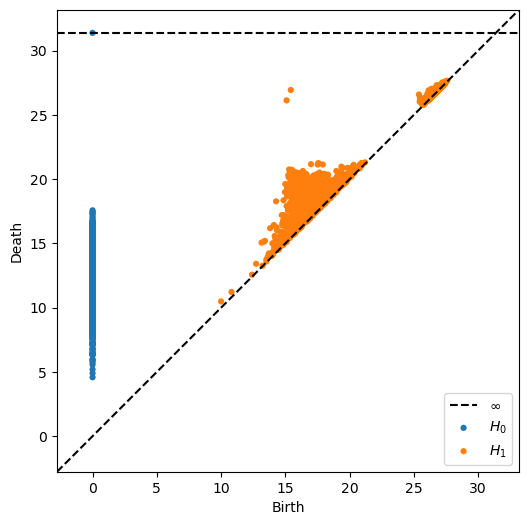

In [73]:
plot_dgms(output)

In [74]:
persistent_H1_intervals(output)

[11.517138481140137,
 11.034599304199219,
 5.463481903076172,
 5.301687240600586,
 5.2445068359375,
 5.204353332519531,
 5.188139915466309,
 5.099327087402344,
 5.099098205566406,
 5.090854644775391]

In [75]:
# coeff = 3
output = pipeline(image_function = c4, num_pixels = 40, window_size = 5, n_isos = 2000, x_translate = 100, y_translate = 100, maxdim = 1, coeff = 3)

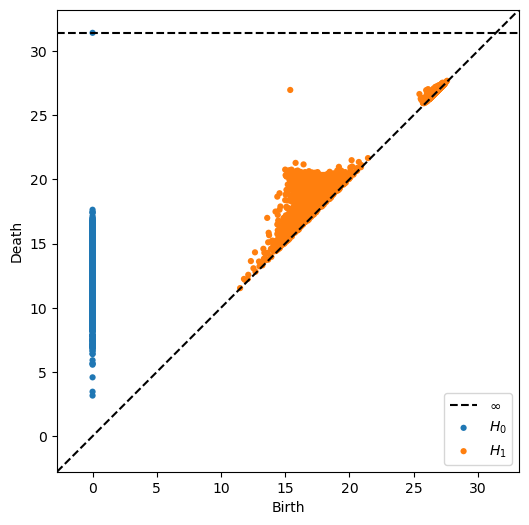

In [76]:
plot_dgms(output)

In [77]:
persistent_H1_intervals(output)

[11.568134307861328,
 5.760540008544922,
 5.498228073120117,
 5.472408294677734,
 5.416844367980957,
 5.382604598999023,
 5.343955039978027,
 5.289104461669922,
 5.268606185913086,
 5.1640119552612305]

These results indicate that there are two $H_1$ homology classes over $Z_2$ and one over $Z_3$, which is what we expect for $C_4$!

## Point Group: $C_1$

**Method 2:**

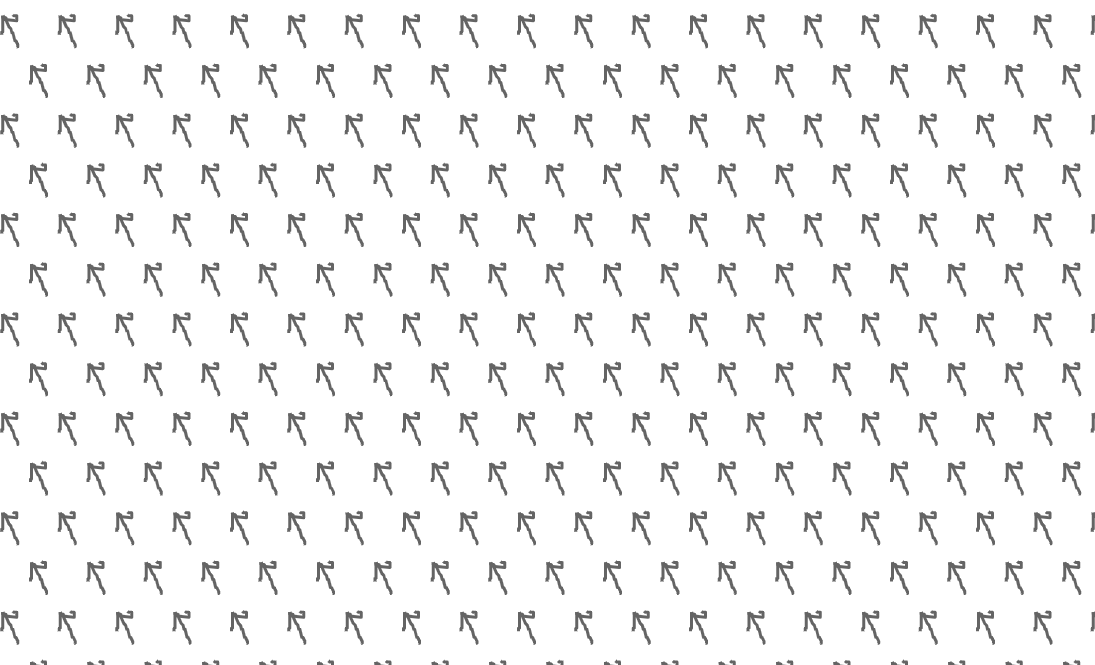

In [4]:
img = Image.open('../images/C1 curly arrow.png')
img = img.convert('L')
display(img)

In [5]:
isoms = generate_isoms(img, 30, 750)
data = get_pixel_isom(isoms, img, 30)

Set k =  13


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

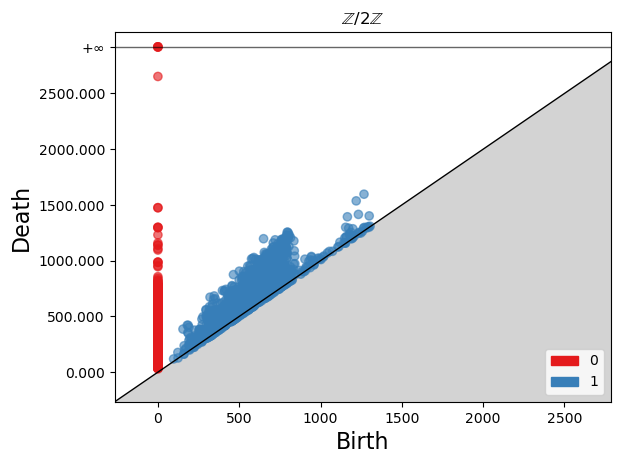

In [11]:
c = 2
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  13


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

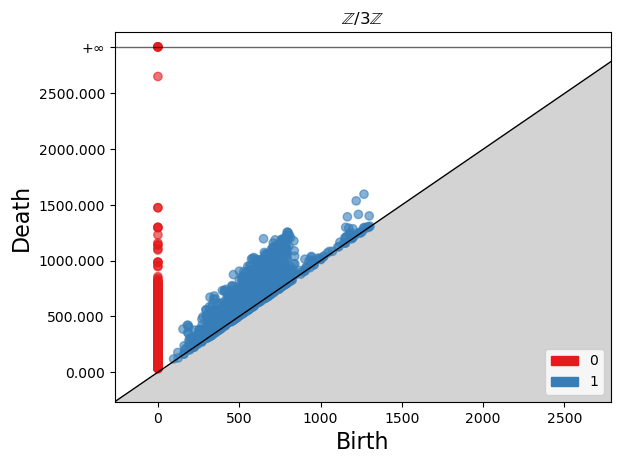

In [12]:
c = 3
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [13]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

0.0

These results seem to indicate that there is one $H_1$ homology classes over $Z_2$ and one over $Z_3$. There should be three homology classes over $Z_2$ and $Z_3$ for the $C_1$ point group.

## Point Group: $C_2$

**Method 1:**

In [34]:
def c2(x,y):
    return sin(2 * x + y) * cos(y)

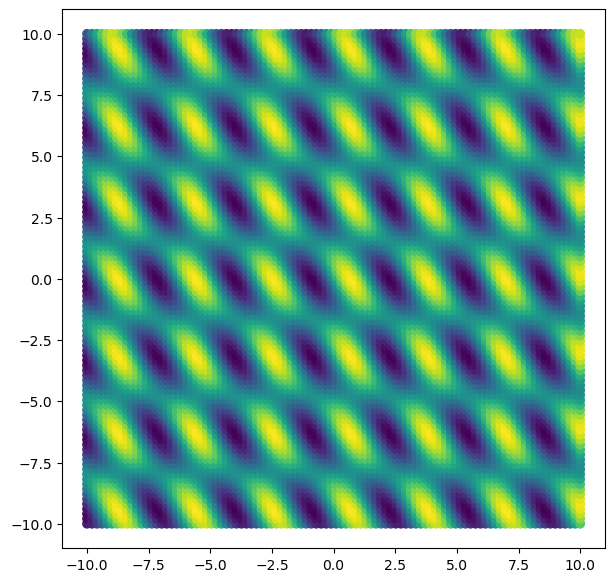

In [37]:
view_window_continuous(c2,100,20)

In [38]:
# coeff = 2
output = pipeline(image_function = c2, num_pixels = 40, window_size = 10, n_isos = 2000, x_translate = 100, y_translate = 100, maxdim = 1, coeff = 2)

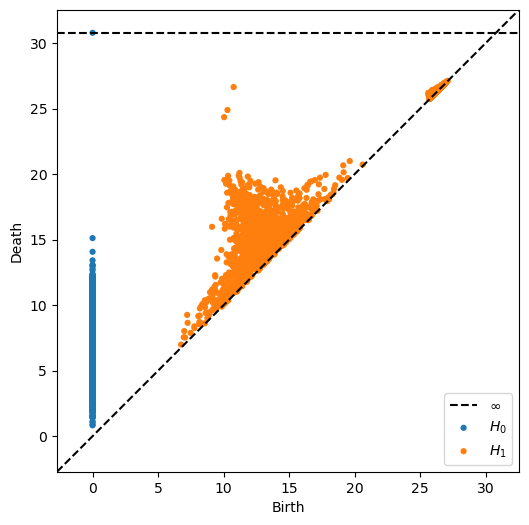

In [39]:
plot_dgms(output)

In [40]:
persistent_H1_intervals(output)

[15.875365257263184,
 14.591273307800293,
 14.305240631103516,
 9.526734352111816,
 9.49075984954834,
 9.107195854187012,
 9.080289840698242,
 9.07056999206543,
 8.878910064697266,
 8.740416526794434]

In [45]:
#coeff = 3
output = pipeline(image_function = c2, num_pixels = 40, window_size = 10, n_isos = 2000, x_translate = 100, y_translate = 100, maxdim = 1, coeff = 3)

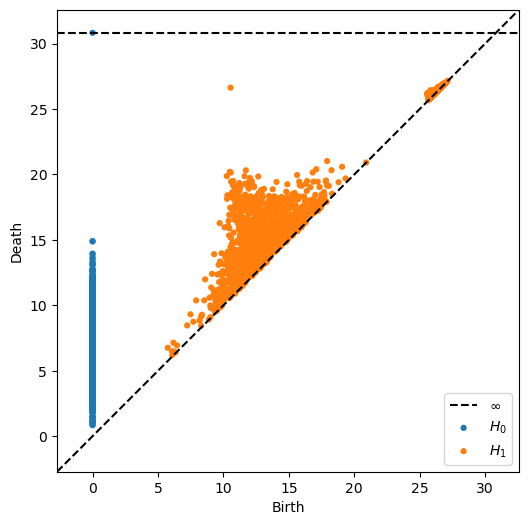

In [42]:
plot_dgms(output)

In [43]:
persistent_H1_intervals(output)

[16.082262992858887,
 9.704489707946777,
 9.616801261901855,
 9.585009574890137,
 8.86721134185791,
 8.744765281677246,
 8.598189353942871,
 8.438361167907715,
 8.253716468811035,
 8.124443054199219]

These results indicate that there are three $H_1$ homology classes over $Z_2$ and one over $Z_3$, which is what we expect from $C_2$!

**Method 2:**

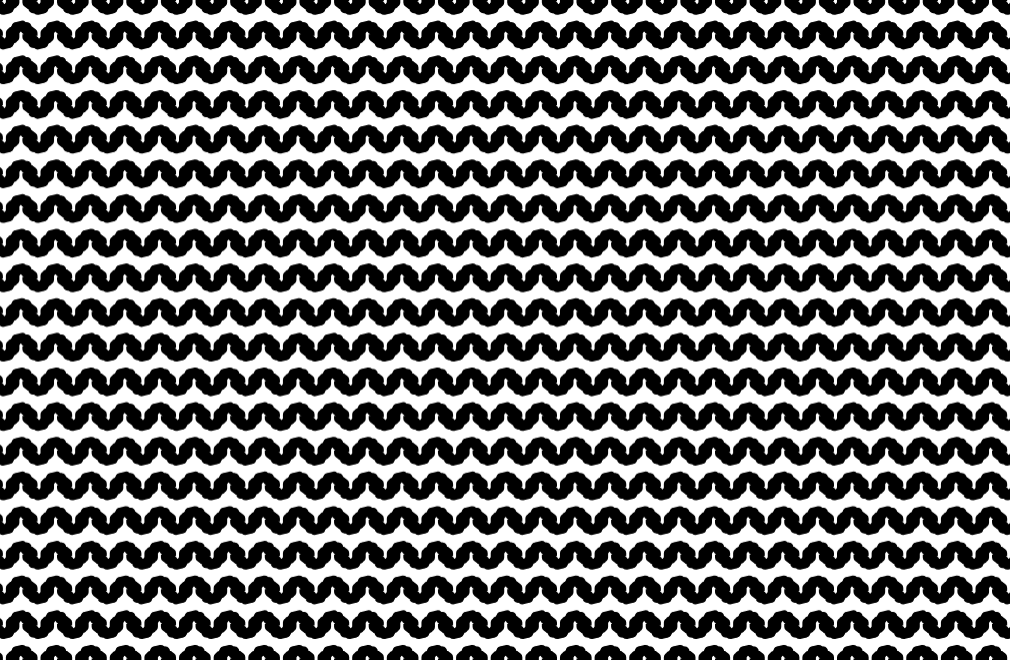

In [24]:
img = Image.open('images/C2sqiggle.png')
img = img.convert('L')
display(img)

largest 7 lengths of H1 intervals
[1861.494140625, 1664.245361328125, 1325.875244140625, 1307.322265625, 1293.91845703125, 1292.794921875, 1288.88720703125]


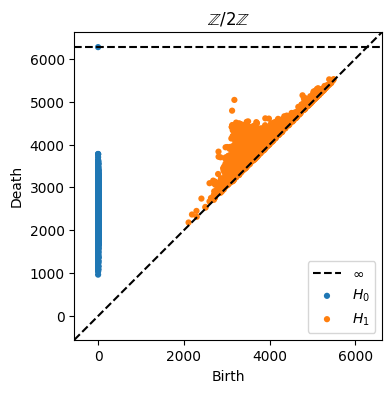

In [26]:
persistent_homology(img, 38, 2000, 2)

largest 7 lengths of H1 intervals
[1777.11474609375, 1418.638671875, 1401.934326171875, 1389.041259765625, 1377.953857421875, 1341.848876953125, 1335.78857421875]


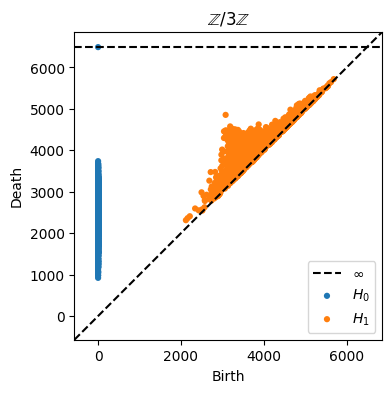

In [27]:
persistent_homology(img, 38, 2000, 3)

These results indicate that there are two $H_1$ homology classes over $Z_2$ and one over $Z_3$, which is what we expect from $C_4$, not $C2$. Looking at another image:

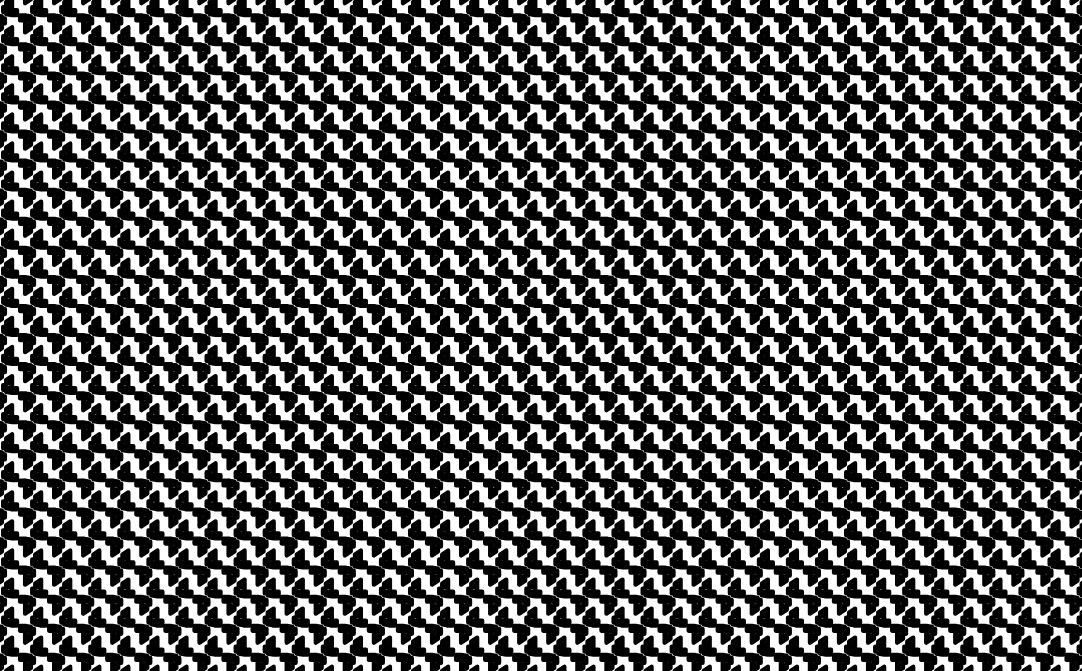

In [29]:
img = Image.open('images/C2bow.png')
img = img.convert('L')
display(img)

largest 7 lengths of H1 intervals
[1711.6845703125, 1691.039794921875, 1478.705322265625, 1446.47021484375, 1423.912353515625, 1422.50146484375, 1401.372802734375]


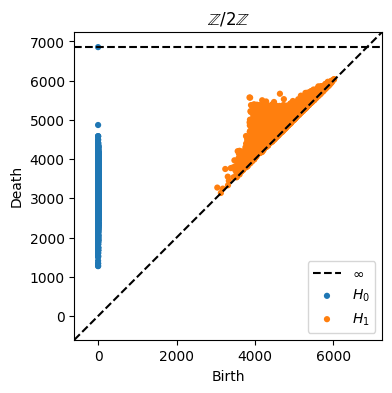

In [34]:
persistent_homology(img, 40, 2000, 2)

largest 7 lengths of H1 intervals
[1676.17431640625, 1483.307861328125, 1462.062744140625, 1438.022705078125, 1429.2607421875, 1409.2333984375, 1398.899169921875]


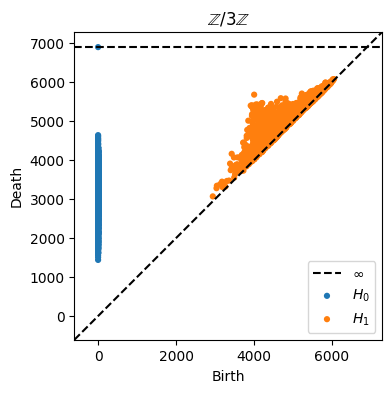

In [32]:
persistent_homology(img, 40, 2000, 3)

With this image, the signal is very weak and is all effectively noise.

## Point Group $C_3$

**Method 1:**

**Method 2:**

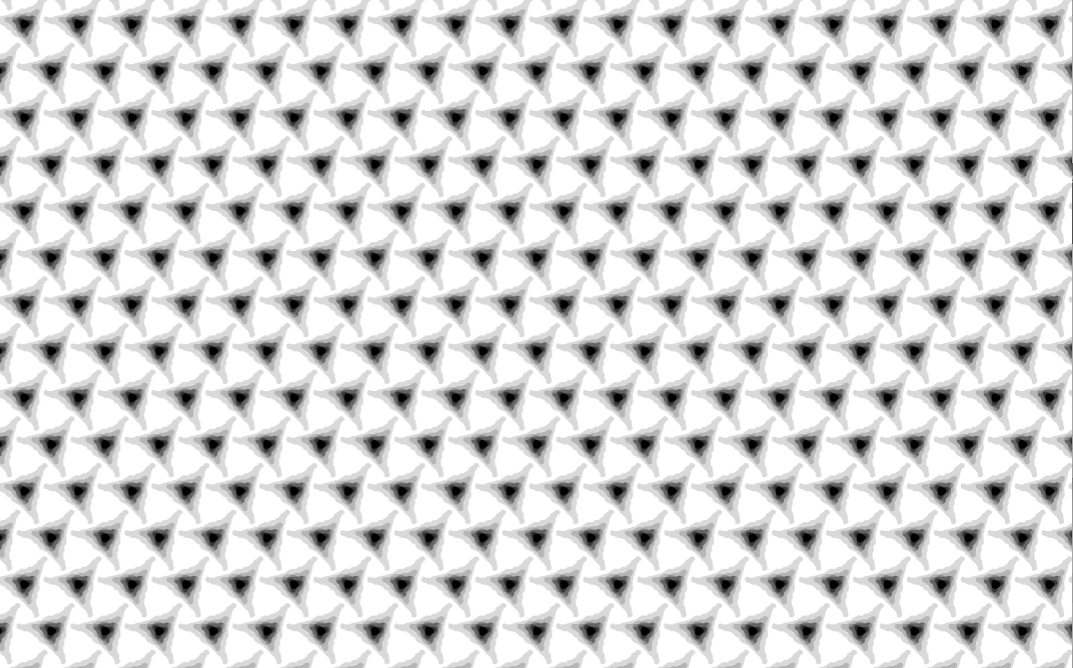

In [4]:
img = Image.open('../images/C3gradient.png')
img = img.convert('L')
display(img)

In [5]:
isoms = generate_isoms(img, 70, 750)
data = get_pixel_isom(isoms, img, 70)


Set k =  8
CPU times: total: 1min 40s
Wall time: 3min 22s


C:\Users\dinko\anaconda3\envs\persistent-homology\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

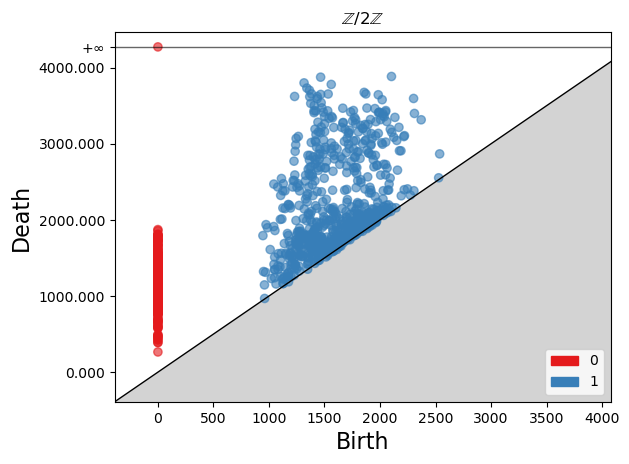

In [6]:
%%time
c = 2
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8
CPU times: total: 1min 40s
Wall time: 3min 20s


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

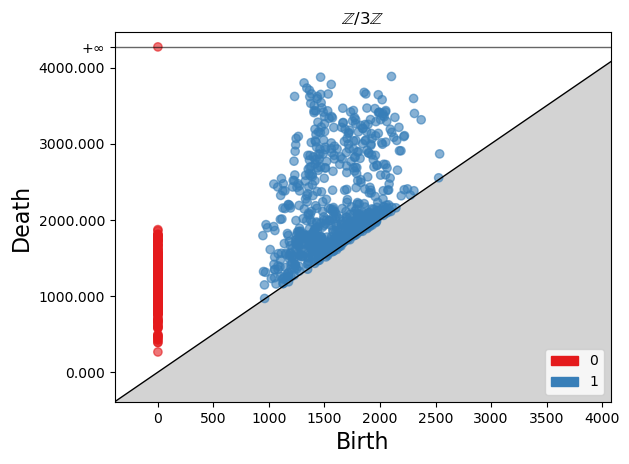

In [7]:
%%time
c = 3
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [8]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

0.0

Even though the size of the lens increased, the runtime was nearly the same. Very noisy output, will try increasing lens size.

In [9]:
isoms = generate_isoms(img, 160, 750)
data = get_pixel_isom(isoms, img, 160)

Set k =  8
CPU times: total: 1min 55s
Wall time: 3min 50s


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

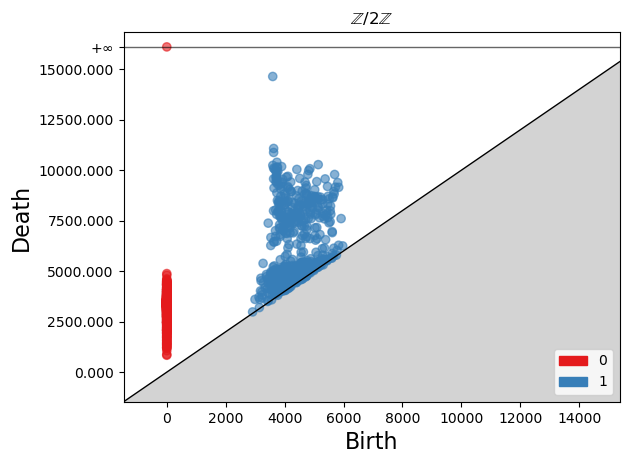

In [10]:
%%time
c = 2
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8
CPU times: total: 1min 53s
Wall time: 3min 41s


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

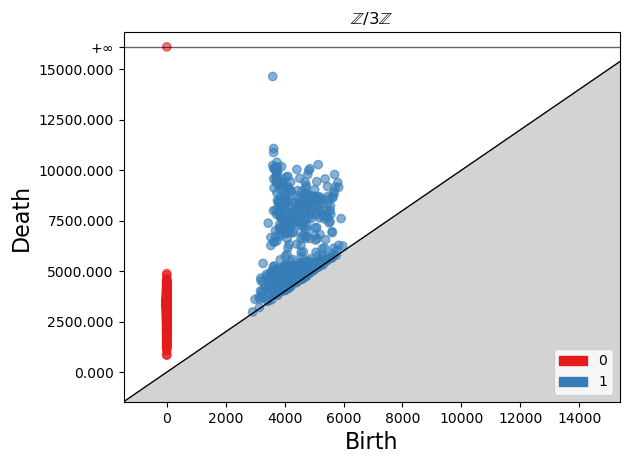

In [11]:
%%time
c = 3
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [12]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

0.0

better output, similar but worse (20 seconds) speed. Still not correctly identifying C3 group.

I'm going to try a bigger lens out of curiosity.

In [13]:
isoms = generate_isoms(img, 320, 750)
data = get_pixel_isom(isoms, img, 320)

Set k =  8
CPU times: total: 2min 31s
Wall time: 5min 10s


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

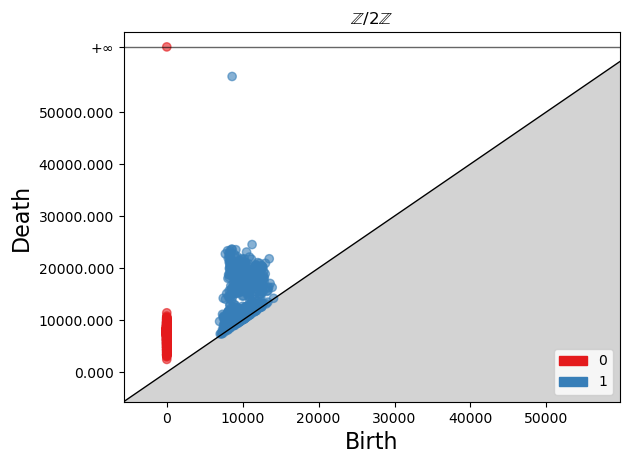

In [14]:
%%time
c = 2
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8
CPU times: total: 2min 34s
Wall time: 5min


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

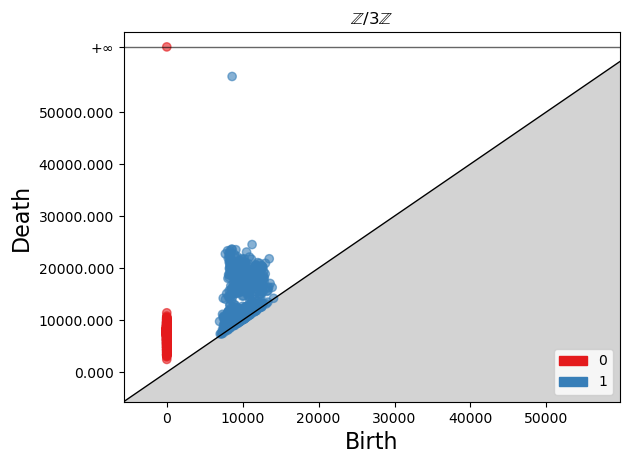

In [15]:
%%time
c = 3
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [16]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

0.0

## Point Group $C_6$

**Method 1:**

In [52]:
def c6(x,y):
    X = 1/(2 * pi) * (x + y / (3**(1/2)))
    Y = 1/(2 * pi) * 2 * y / (3**(1/2))
    C = cos(X + Y) + cos(X - 2 * Y) + cos(-2 * X + Y)
    S = sin(X + Y) +sin(X - 2*Y) +sin(-2 * X + Y)
    return C 

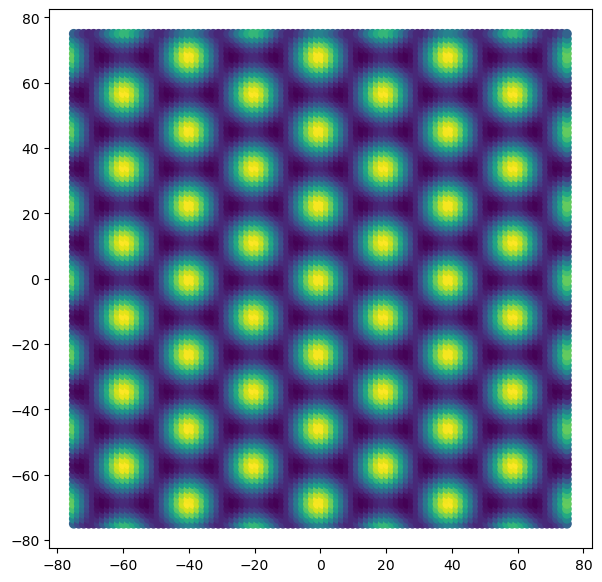

In [80]:
view_window_continuous(c6,100,150)

In [81]:
# coeff = 2
output = pipeline(image_function = c6, num_pixels = 40, window_size = 50, n_isos = 2000, x_translate = 1000, y_translate = 1000, maxdim = 1, coeff = 2)

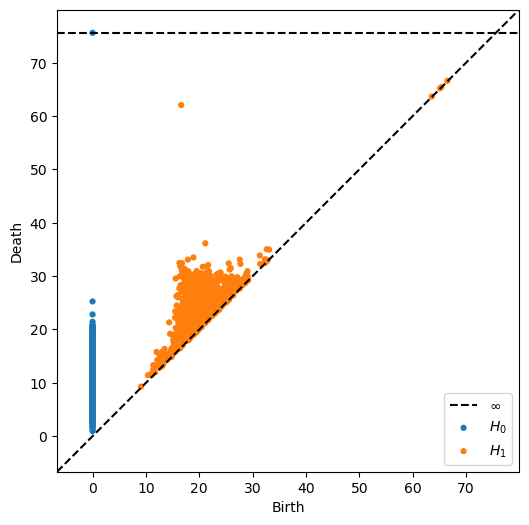

In [82]:
plot_dgms(output)

In [83]:
persistent_H1_intervals(output)

[45.45123291015625,
 16.18950653076172,
 15.65781021118164,
 15.412734985351562,
 15.237525939941406,
 15.032224655151367,
 14.694974899291992,
 14.593942642211914,
 14.443723678588867,
 14.420331954956055]

In [53]:
# coeff = 3
output = pipeline(image_function = c6, num_pixels = 40, window_size = 50, n_isos = 2000, x_translate = 1000, y_translate = 1000, maxdim = 1, coeff = 3)

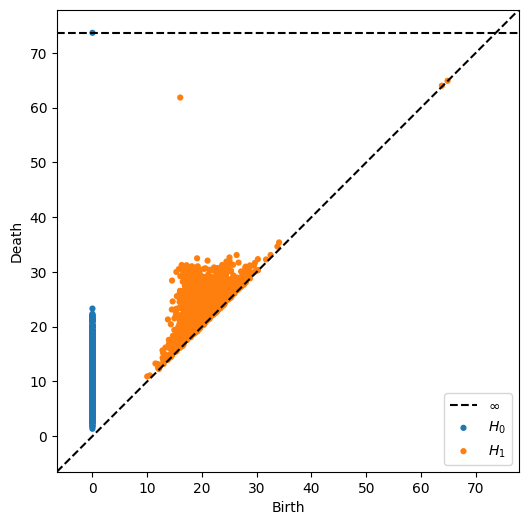

In [54]:
plot_dgms(output)

In [55]:
persistent_H1_intervals(output)

[45.81563186645508,
 14.960275650024414,
 14.730281829833984,
 14.662679672241211,
 14.642820358276367,
 14.462339401245117,
 14.037059783935547,
 13.886065483093262,
 13.871101379394531,
 13.550107955932617]

These results indicate that there is one $H_1$ homology class over $Z_2$ and one over $Z_3$, which is what we expect for $C_6$!

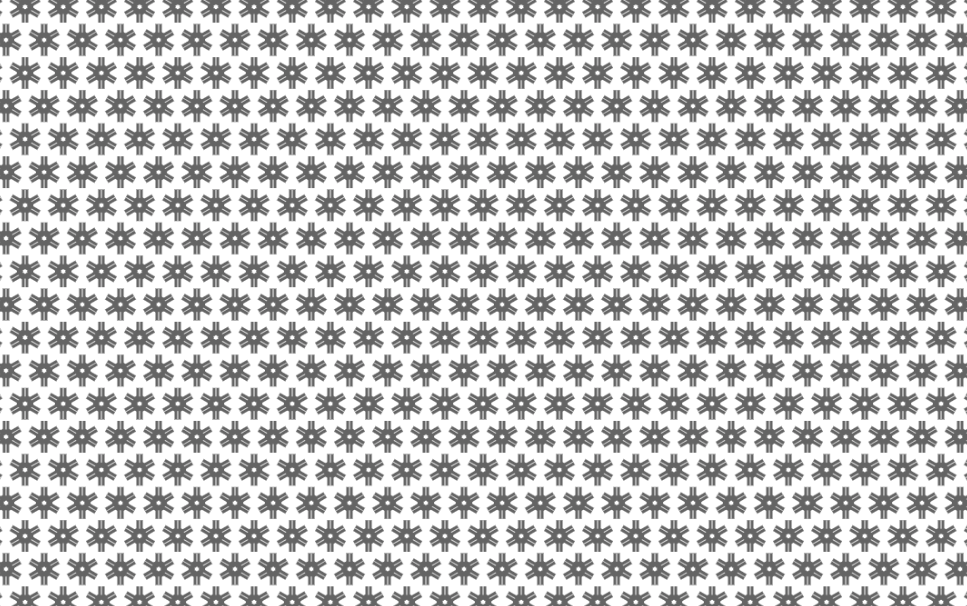

In [56]:
img_names = glob.glob('images/*C6 star.png')
img = Image.open(img_names[0])
display(img)

/Users/shannagoldman/anaconda3/envs/my-env/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[5798.0703125, 3000.7490234375, 2987.306640625, 2963.97265625, 2943.38671875, 2845.4404296875, 2844.279296875]


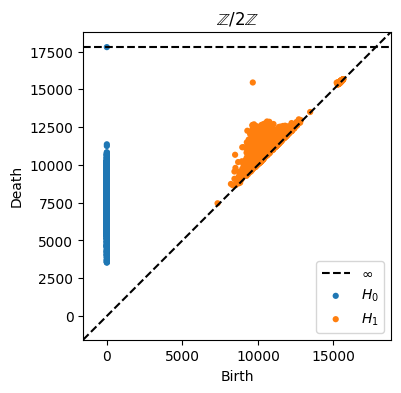

In [57]:
persistent_homology(img, 100, 2000, 2)

/Users/shannagoldman/anaconda3/envs/my-env/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[5898.599609375, 3164.8388671875, 2999.1181640625, 2947.974609375, 2892.4560546875, 2856.578125, 2852.4189453125]


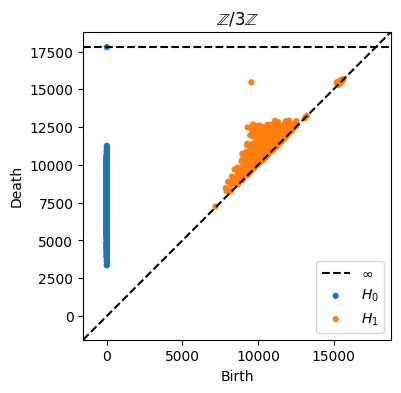

In [58]:
persistent_homology(img, 100, 2000, 3)

These results indicate that there is one $H_1$ homology class over $Z_2$ and one over $Z_3$, which is what we expect for $C_6$!